In [3]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Simple linear regression

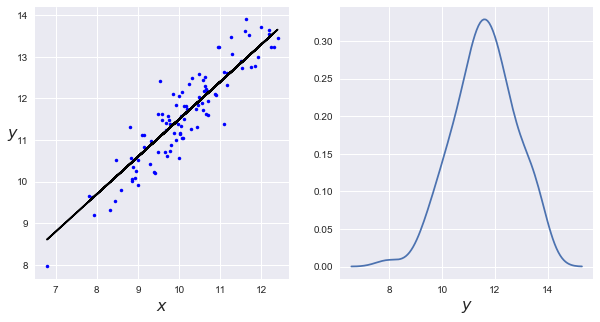

In [2]:
np.random.seed(314)
n = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=n)

x = np.random.normal(10, 1, n)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k') # k is black, without a dot the points are connected by lines; since they're all in the same line we see a single line
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

In [3]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)

Optimization terminated successfully.
         Current function value: 72.345620
         Iterations: 13
         Function evaluations: 23
         Gradient evaluations: 23


100%|██████████| 10000/10000 [00:02<00:00, 3872.65it/s]


In [4]:
chain = trace[200:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bdd35c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11db00358>]], dtype=object)

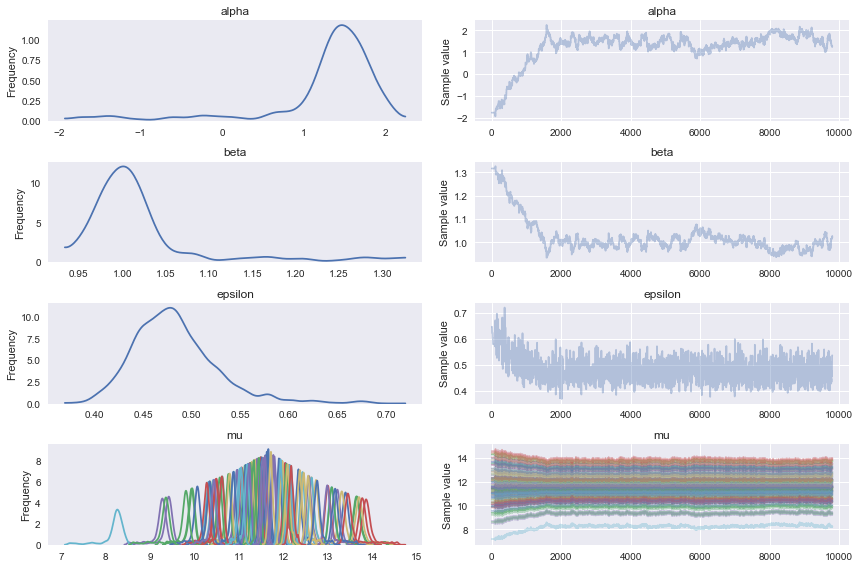

In [5]:
pm.traceplot(chain)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11efeccc0>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11f3f9208>]], dtype=object)

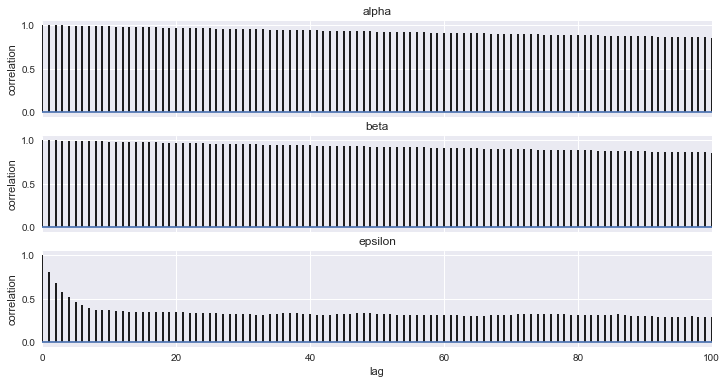

In [6]:
pm.autocorrplot(chain, ['alpha','beta','epsilon'])

In [7]:
# this is only effective in pymc3 when we have more than one trace - 
# why? doesn't the formula for using auto-correlation/getting ESS
# hold for a single chain? 
#pm.effective_n(chain)

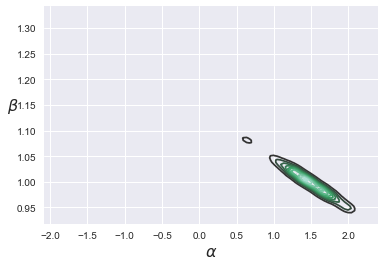

In [8]:
sns.kdeplot(chain['alpha'], chain['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

What if we center x?

In [9]:
np.mean(x)

10.129192299164298

In [10]:
x_centered = x - np.mean(x)
np.mean(x_centered)

2.7533531010703882e-16

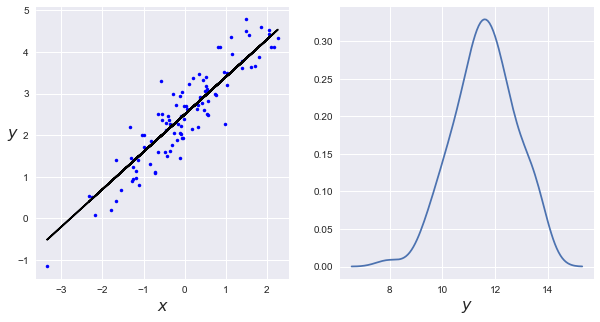

In [11]:
y_real_with_centered_x = alpha_real + beta_real * x_centered
y_with_centered_x = y_real_with_centered_x + eps_real

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x_centered, y_with_centered_x, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_centered, y_real_with_centered_x, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)

In [12]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x_centered)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_with_centered_x)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start)

Optimization terminated successfully.
         Current function value: 72.361106
         Iterations: 13

100%|██████████| 10000/10000 [00:02<00:00, 3649.67it/s]


         Function evaluations: 24
         Gradient evaluations: 24


In [13]:
chain = trace[200:]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f8df860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12090e240>]], dtype=object)

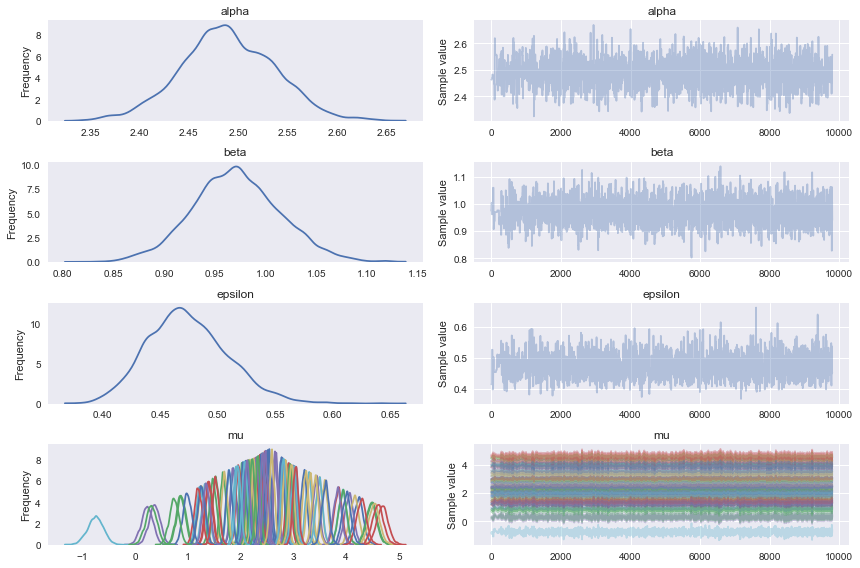

In [14]:
pm.traceplot(chain)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11cdf4588>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11bd70550>]], dtype=object)

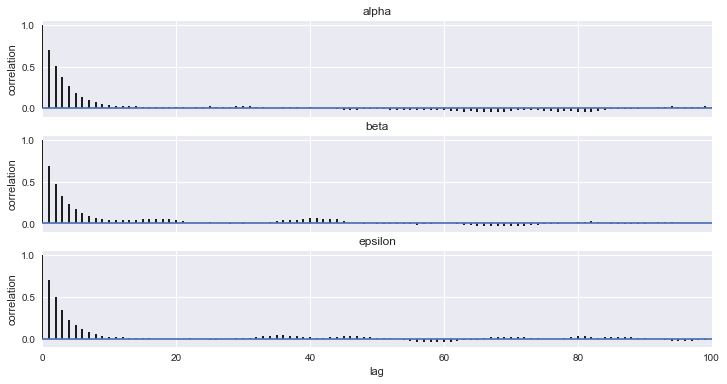

In [15]:
pm.autocorrplot(chain, ['alpha','beta','epsilon'])

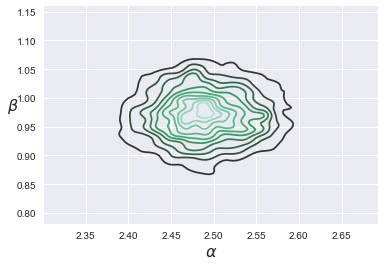

In [16]:
sns.kdeplot(chain['alpha'], chain['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

# Robust linear regression

In [17]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans['dataset'] == 'III']['x'].values
y_3 = ans[ans['dataset'] == 'III']['y'].values

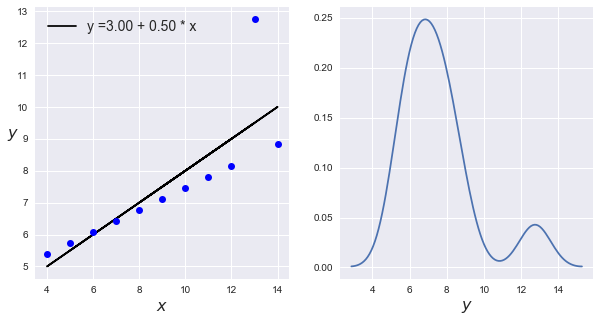

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k', label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'bo')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)

In [19]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) +1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha+beta*x_3, 
                         sd=epsilon, nu=nu, observed=y_3)

    # if you do this then the result shown below will be the same
    # as the least squares approach
    #     y_pred = pm.Normal('y_pred', mu=alpha+beta*x_3, 
    #                          sd=epsilon, observed=y_3)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -3.0619: 100%|██████████| 200000/200000 [00:17<00:00, 11164.82it/s]
Finished [100%]: Average ELBO = -3.1169
100%|██████████| 2000/2000 [00:08<00:00, 228.31it/s]


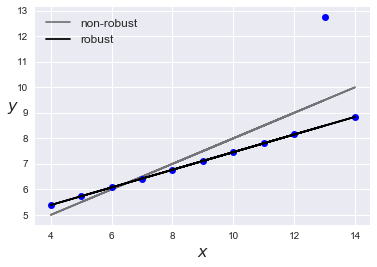

In [20]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'bo')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)

100%|██████████| 200/200 [00:01<00:00, 108.31it/s]
/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


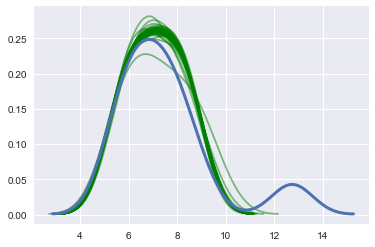

In [21]:
ppc = pm.sample_ppc(trace_t, samples=200, model=model_t)
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, c='g')
sns.kdeplot(y_3, linewidth=3)

# Hierarchical linear regression

In [26]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)

alpha_real = np.random.normal(6, 10, size=M) # intercept
beta_real = np.random.normal(2.5, 0.5, size=M) # slope
eps_real = np.random.normal(0, 0.5, size=len(idx)) # error

#y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

In [27]:
alpha_real

array([  3.68509346,   2.42470071,  23.11784735,  10.73427839,
         8.99566113,  12.03874115, -11.77442557,  10.28855952])

In [28]:
beta_real

array([ 2.71780045,  2.91537221,  3.00692104,  2.42581325,  1.78014642,
        2.38077258,  2.1910569 ,  2.71709041])

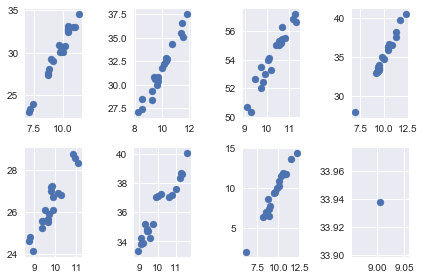

In [29]:
j, k = 0, N
for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    #plt.xlim(6, 15)
    #plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [31]:
x_m[:10]

array([ 10.46233044,   8.74533519,  10.46356398,   8.96274404,
        10.45183501,   7.078091  ,   8.82522626,   8.7770602 ,
         9.88868799,   7.42841108])

In [32]:
x_centered = x_m - x_m.mean()
x_centered[:10]

array([  5.74256681e-01,  -1.14273856e+00,   5.75490218e-01,
        -9.25329714e-01,   5.63761249e-01,  -2.80998275e+00,
        -1.06284750e+00,  -1.11101356e+00,   6.14230688e-04,
        -2.45966268e+00])

In [34]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.StudentT('y_pred', 
                         mu=alpha_tmp[idx] + beta[idx]*x_centered,
                         sd=epsilon,
                         nu=nu,
                         observed=y_m)
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta*x_m.mean())
    
    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -329.76: 100%|██████████| 200000/200000 [00:22<00:00, 9084.21it/s]
Finished [100%]: Average ELBO = -324.61
100%|██████████| 2000/2000 [01:56<00:00, 17.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1232b46d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125eac9e8>]], dtype=object)

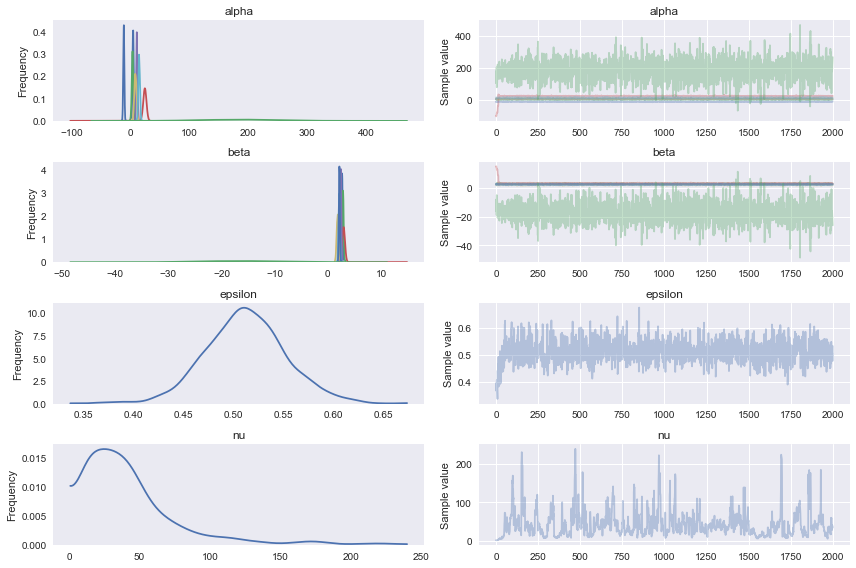

In [35]:
varnames = ['alpha','beta','epsilon','nu']
pm.traceplot(trace_up, varnames)

In [38]:
with pm.Model() as hierarchical_model:
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)
    
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, 
                          sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    
    y_pred = pm.StudentT('y_pred', 
                         mu=alpha_tmp[idx] + beta[idx] * x_centered,
                         sd=epsilon,
                         nu=nu,
                         observed=y_m)
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean())
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    mu, sds, elbo = pm.variational.advi(n=100000)
    cov_scal = np.power(hierarchical_model.dict_to_array(sds), 2)
    step = pm.NUTS(scaling=cov_scal, is_cov=True)
    trace_hm = pm.sample(1000, step=step, start=mu)

Average ELBO = -582.79: 100%|██████████| 100000/100000 [00:16<00:00, 6230.67it/s]
Finished [100%]: Average ELBO = -554.78
100%|██████████| 1000/1000 [00:54<00:00, 18.40it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129f88320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a9fb198>]], dtype=object)

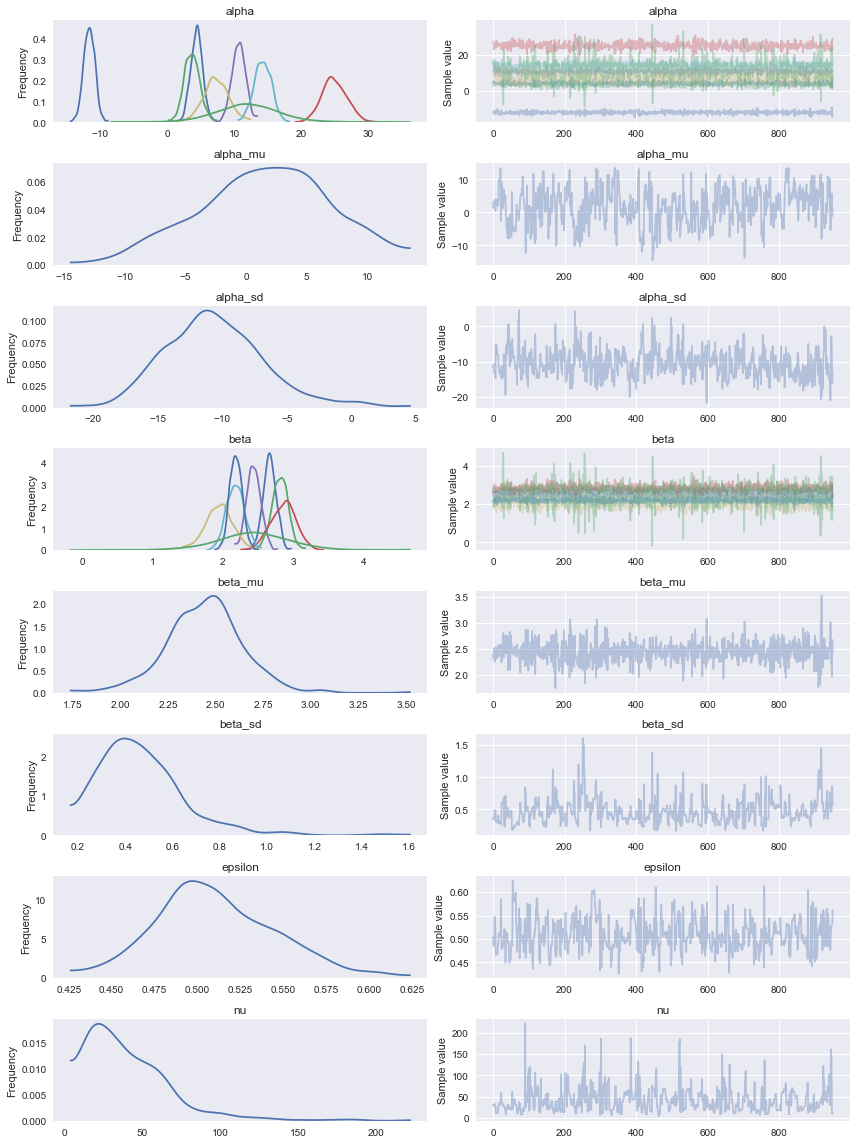

In [48]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta', 'beta_mu', 'beta_sd', 'epsilon', 'nu']
trace_hm_after_burnin = trace_hm[50:]

pm.traceplot(trace_hm_after_burnin, varnames)

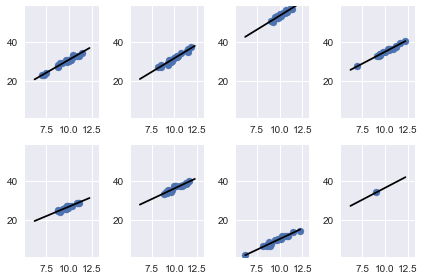

In [49]:
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    alfa_m = trace_hm_after_burnin['alpha'][:,i].mean()
    beta_m = trace_hm_after_burnin['beta'][:,i].mean()
    plt.plot(x_range, alfa_m+beta_m*x_range, 
             c='k', label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

plt.tight_layout()

# Multiple linear regression

In [4]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10,2],[1,1.5])])
y = alpha_real + np.dot(beta_real, X) + eps_real

X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean

In [13]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

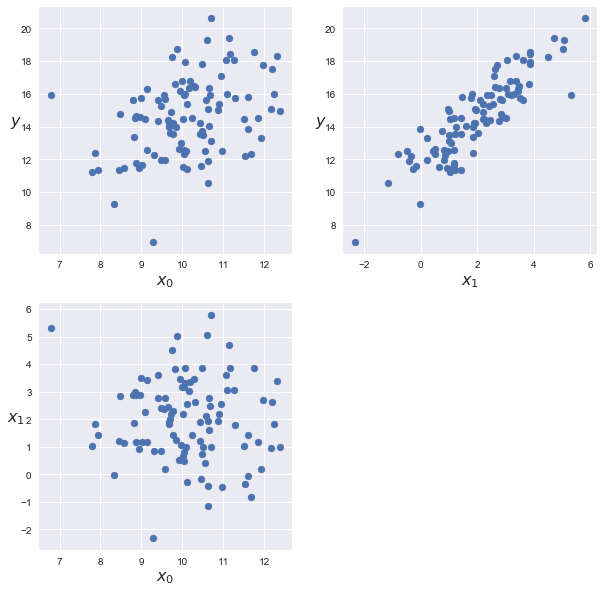

In [15]:
scatter_plot(X, y)

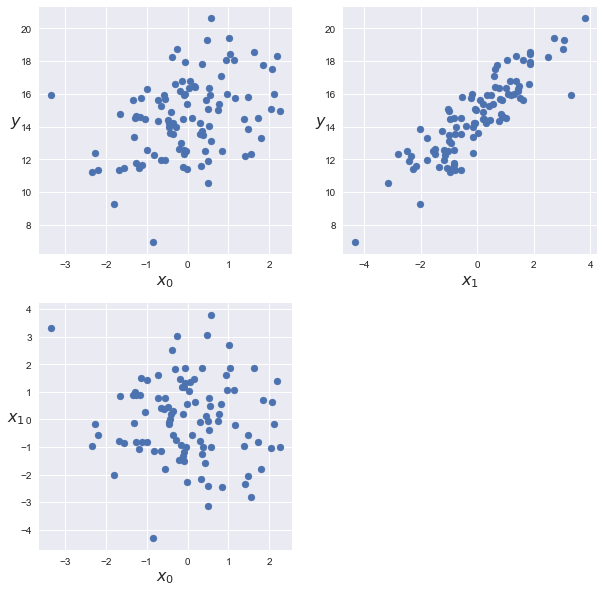

In [16]:
scatter_plot(X_centered, y)

In [17]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha_tmp + pm.math.dot(beta, X_centered)
    
    # use pm.math.dot because beta is a Theano tensor, not 
    # a NumPy array
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean))
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_mlr = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 74.986175
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31


100%|██████████| 5000/5000 [00:06<00:00, 780.20it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d2267b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12148e7b8>]], dtype=object)

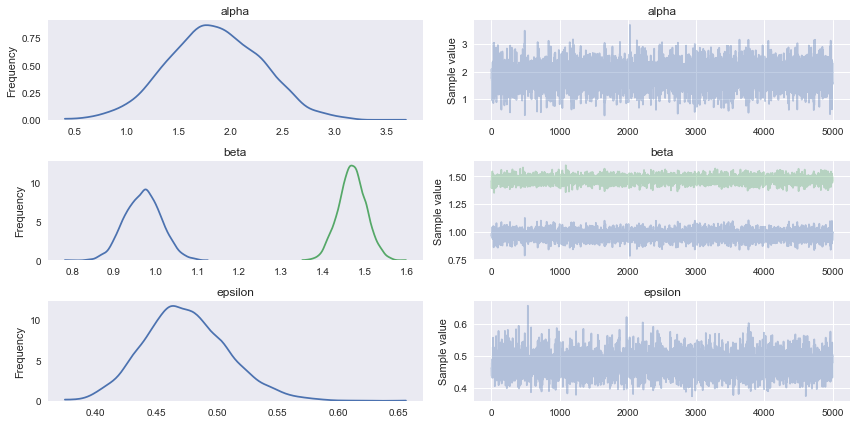

In [19]:
varnames = ['alpha', 'beta', 'epsilon']
pm.traceplot(trace_mlr, varnames)

In [20]:
pm.df_summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha__0,1.844173,0.450332,0.006417,0.939790,2.681562
beta__0,0.969395,0.043350,0.000618,0.887195,1.054802
beta__1,1.470196,0.032957,0.000439,1.405144,1.534363
epsilon,0.473979,0.034496,0.000545,0.407214,0.542197


## Confounding variables

In [21]:
# x_1 is the confounder
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1,x_2))

This data - because of how it's created - is already centered and has a standard deviation of one... at least that's what the text says. I don't see this closely, as below - perhaps it's close enough and the differences are just from randomness?

In [27]:
X.mean(axis=1), y.mean()

(array([-0.00969626,  0.03260018]), 0.098941457574259178)

In [28]:
X.std(axis=1), y.std()

(array([ 0.86558116,  1.31597237]), 1.2506848077264769)

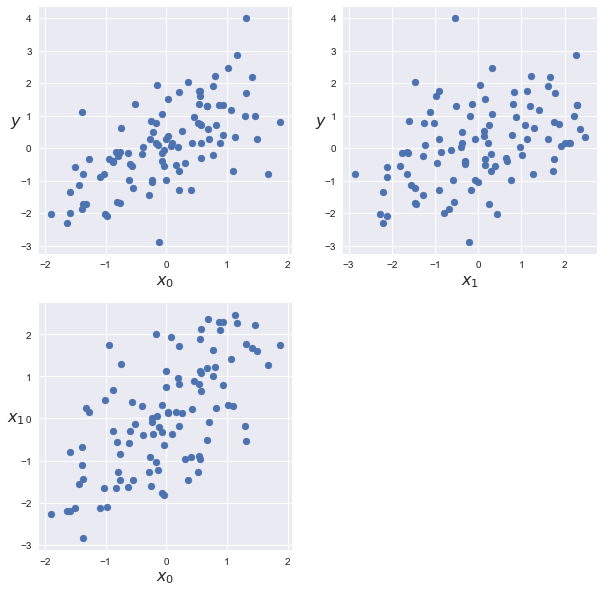

In [29]:
scatter_plot(X, y)

In [30]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + pm.math.dot(beta, X)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 150.556539

100%|██████████| 5000/5000 [00:05<00:00, 923.88it/s] 


         Iterations: 15
         Function evaluations: 20
         Gradient evaluations: 20


In [31]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.106591,0.098629,0.001474,-0.084373,0.303402
beta__0,0.896842,0.149814,0.003247,0.612831,1.201200
beta__1,0.014901,0.099566,0.002032,-0.168689,0.222484
epsilon,0.996392,0.072183,0.001150,0.859009,1.134516


Note that beta_1 is close to zero, which means this model is showing almost no contribution to y by x_2. Here we have x_1 still, linked to beta_0.

In [36]:
# now do it with just x_1 and no x_2
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta_1', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + pm.math.dot(beta, x_1)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 147.347680
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16


100%|██████████| 5000/5000 [00:04<00:00, 1235.94it/s]


In [37]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.107089,0.098667,0.001613,-0.088684,0.296925
beta_1,0.912154,0.113354,0.001547,0.692722,1.137980
epsilon,0.990424,0.071485,0.001040,0.847942,1.126813


In [38]:
# and now with just x_2
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta_2', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + pm.math.dot(beta, x_2)
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_red = pm.sample(5000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 163.031203
         Iterations: 13


100%|██████████| 5000/5000 [00:04<00:00, 1062.45it/s]

         Function evaluations: 17
         Gradient evaluations: 17


In [39]:
pm.df_summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.083786,0.116595,0.001622,-0.131835,0.325752
beta_2,0.396837,0.087359,0.001221,0.227550,0.560846
epsilon,1.161455,0.081740,0.001262,1.014643,1.330297


Overall the section on 'Multiple linear regression' covers (some? all?) of the common gotchas wi